In [11]:
from flask import Flask, request, render_template_string, redirect, url_for, render_template
from flask import Flask, render_template, request, redirect, url_for, session
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
import base64
from datetime import datetime
import bcrypt
import os
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import random
import string
import nbimporter
import current_tournament_leaderboard
import current_tournament_information

In [14]:
app = Flask(__name__)
app.secret_key = os.environ.get('FLASK_SECRET_KEY', 'penguin123crazy1--')
app.config['SESSION_PERMANENT'] = False
app.config['SESSION_TYPE'] = 'filesystem'

db_creds = pd.read_csv('/users/zack burnside/desktop/database_creds.csv')

# Functions
def authenticate_user(username, password):
    try:
        conn = get_db_connection()
        cur = conn.cursor()

        query = """
            SELECT password
            FROM public.user_logins
            WHERE username = %s
        """
        cur.execute(query, (username,))
        result = cur.fetchone()

        if result:
            stored_password = result[0]
            if stored_password == password:
                return True
            else:
                print("Password does not match.")
                return False
        else:
            print("Username not found.")
            return False

    except psycopg2.Error as e:
        print(f"Database error during authentication: {e}")
        return False
    except Exception as e:
        print(f"Error during authentication: {e}")
        return False
    finally:
        cur.close()
        conn.close()

def get_db_connection():
    conn = psycopg2.connect(
        dbname=db_creds['dbname'][0],
        user=db_creds['user'][0],
        password=db_creds['password'][0],
        host=db_creds['host'][0],
        port=db_creds['port'][0]
    )
    return conn

def fetch_user_results(username=None):
    conn = get_db_connection()
    cur = conn.cursor()
    if username:
        cur.execute("SELECT user_name, player_pick, prize_money, tournament_name FROM public.weekly_tournament_results WHERE user_name = %s", (username,))
    else:
        cur.execute("SELECT user_name, player_pick, prize_money, tournament_name FROM public.weekly_tournament_results")
    results = cur.fetchall()
    cur.close()
    conn.close()
    return results

def fetch_tournament_info(tournament_name):
    conn = get_db_connection()
    cur = conn.cursor()
    cur.execute("""
        SELECT DISTINCT index, tournament_name, dates, 
        to_char(purse::numeric, 'FM$999,999,999,999.00') 
        FROM public.tournament_info
        WHERE tournament_name = %s
    """, (tournament_name,))
    results = cur.fetchall()
    cur.close()
    conn.close()
    return results

def fetch_tournament_results(tournament_name):
    conn = get_db_connection()
    cur = conn.cursor()
    cur.execute("""
        SELECT user_name, player_pick, prize_money 
        FROM public.weekly_tournament_results 
        WHERE tournament_name = %s
    """, (tournament_name,))
    results = cur.fetchall()
    cur.close()
    conn.close()
    return results

def insert_pick(username, tournament, pick):
    conn = get_db_connection()

    cur = conn.cursor()
    cur.execute("""
        INSERT INTO public.weekly_tournament_results (user_name, tournament_name, player_pick)
        VALUES (%s, %s, %s)
    """, (username, tournament, pick))
    conn.commit()
    cur.close()
    conn.close()

def fetch_stats_data():
    conn = get_db_connection()
    cursor = conn.cursor()
    cursor.execute("SELECT player_pick, COUNT(*) as pick_count FROM public.user_picks GROUP BY player_pick ORDER BY pick_count DESC")
    data = cursor.fetchall()
    conn.close()
    return data

def leaderboard_chart():
    # Fetch leaderboard data and convert it to a DataFrame
    df = pd.DataFrame(fetch_leaderboard(), columns=['username', 'prize_money'])
    
    # Create a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(df['username'], df['prize_money'], color='skyblue')
    
    # Add titles and labels
    plt.title('Leaderboard - Total Prize Money by User')
    plt.xlabel('User')
    plt.ylabel('Total Prize Money')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Add grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Display the chart
    plt.tight_layout()
    plt.show()

def create_bar_chart(data):
    golfers = [row[0] for row in data]
    pick_count = [row[1] for row in data]

    fig, ax = plt.subplots(figsize=(20, 12))
    bars = ax.bar(golfers, pick_count, color='skyblue')

    for bar in bars:
        count_value = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count_value), ha='center', va='bottom', fontsize=8)

    ax.set_title('Most Picked Golfer', fontsize=12)
    ax.set_xlabel('Golfer Name', fontsize=10)
    ax.set_ylabel('Pick Count', fontsize=10)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()

    # Convert plot to PNG image and encode it in base64
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    plot_data = buffer.getvalue()
    buffer.close()
    plot_data = base64.b64encode(plot_data).decode('utf-8')
    plt.close()

    return plot_data

def insert_pick(username, tournament, pick):
    conn = get_db_connection()
    cursor = conn.cursor()
    cursor.execute(
        "INSERT INTO user_picks (user_name, tournament_name, player_pick) VALUES (%s, %s, %s)",
        (username, tournament, pick)
    )
    conn.commit()
    cursor.close()
    conn.close()

def fetch_leaderboard():
    conn = get_db_connection()
    cursor = conn.cursor()
    cursor.execute("""
        SELECT user_name AS username, SUM(prize_money) AS total_prize_money
        FROM public.weekly_tournament_results
        GROUP BY user_name
        ORDER BY total_prize_money DESC
    """)
    return cursor.fetchall()


# App Route
@app.route('/login', methods=['GET', 'POST'])
def login():
    session.clear()  # Clear the session data
    
    if request.method == 'POST':
        username = request.form['username']
        password = request.form['password']

        if authenticate_user(username, password):
            session['username'] = username
            session.permanent = False  # Session expires when the browser is closed
            return redirect(url_for('home'))
        else:
            return render_template('login.html', error='Invalid username or password')

    return render_template('login.html')

@app.route('/logout', methods=['POST'])
def logout():
    session.pop('username', None)
    return redirect(url_for('login'))

@app.route('/results', methods=['GET', 'POST'])
def results():
    selected_user = None
    if request.method == 'POST':
        selected_user = request.form['username']
    
    results_data = fetch_user_results(selected_user)
    usernames = [row[0] for row in fetch_user_results()]  # Fetch usernames for the dropdown
    
    return render_template_string('results.html', results_data=results_data, usernames=set(usernames), selected_user=selected_user)

@app.route('/')
def home():
    # Redirect to login if not authenticated
    if 'username' not in session:
        return redirect(url_for('login'))
    
    conn = get_db_connection()
    cursor = conn.cursor()

    def total_money_won():
        cursor.execute("SELECT SUM(prize_money) FROM public.weekly_tournament_results;")
        total_money_ = cursor.fetchone()
        return total_money_[0] if total_money_ else 0

    def total_money_left():
        cursor.execute("SELECT SUM(purse::numeric) AS total_purse FROM public.tournament_info WHERE dates::date > CURRENT_DATE;")
        total_money = cursor.fetchone()
        return f"${total_money[0]:,.2f}" if total_money else "$0.00"

    def fetch_leaderboard():
        cursor.execute("""
            SELECT user_name AS username, SUM(prize_money) AS total_prize_money
            FROM public.weekly_tournament_results
            GROUP BY user_name
            ORDER BY total_prize_money DESC
        """)
        return cursor.fetchall()

    try:
        last_winner = 'TBD'
        next_tournament = 'TBD'
        total_moneyWon = total_money_won()
        total_moneyLeft = total_money_left()
        leaderboard_data = fetch_leaderboard()
    except Exception as e:
        print(f"Error fetching data: {e}")
        last_winner, next_tournament, total_moneyWon, total_moneyLeft, leaderboard_data = "N/A", "N/A", 0, 0, []

    cursor.close()
    conn.close()

    if request.method == 'POST':
        username = request.form['username']
        tournament = request.form['tournament']
        pick = request.form['pick']
        
        # Insert the pick into the database
        insert_pick(username, tournament, pick)
        
        return f'Thank you! Your pick is {pick}.'

    usernames = [
        "Z", "Timmy Chips", "Goob", "C", "Steve", "Sus", "DV3", "Jlo", 
        "Ty Dolla $$$", "Ryan", "Mike D", "Mando", "Eddie Buckets", 
        "Garrett", "T Sully"
    ]
    
    tournaments = [
        "WM Phoenix Open", "The Genesis Invitational", "Mexico Open at Vidanta", 
        "Cognizant Classic", "Arnold Palmer Invitational", 
        "THE PLAYERS Championship", "Valspar Championship", "Texas Children's Houston Open", 
        "The Valero Texas Open", "Masters Tournament", "RBC Heritage", "THE CJ CUP Byron Nelson", 
        "Wells Fargo Championship", "PGA Championship", "Charles Schwab Challenge", 
        "RBC Canadian Open", "the Memorial Tournament presented by Workday", "U.S. Open", 
        "Travelers Championship", "Rocket Mortgage Classic", "John Deere Classic", 
        "Genesis Scottish Open", "The Open Championship", "3M Open", "Wyndham Championship", 
        "FedEx St. Jude Championship", "BMW Championship", "TOUR Championship"
    ]

    current_tournament_info = current_tournament_information.tournament_information()

    return render_template(
        'index.html',
        last_winner=last_winner,
        next_tournament=next_tournament,
        total_moneyWon=total_moneyWon,
        usernames=usernames,
        tournaments=tournaments,
        total_moneyLeft=total_moneyLeft,
        current_tournament_info=current_tournament_info,
        leaderboard_data=leaderboard_data
    )

@app.route('/stats')
def stats_page():
    # Fetch data and create chart (example)
    stats_data = fetch_stats_data()  # Function to fetch your data
    plot_data = create_bar_chart(stats_data)  # Function to create your chart

    # Convert plot_data to base64-encoded image (example)

    # HTML content directly in the route function
    html_content = f'''
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Statistics Page</title>
    </head>
    <body>
        <h1>Most Picked Golfer</h1>

        <!-- Display the chart using base64-encoded image -->
        <img src="data:image/png;base64, {plot_data}" alt="Chart">

        <!-- Add other HTML elements as needed -->

    </body>
    </html>
    '''

    return render_template_string(html_content)

@app.route('/tournament_results/<tournament_name>')
def tournament_results(tournament_name):
    results_data = fetch_tournament_results(tournament_name)
    blank_query_data = fetch_tournament_info(tournament_name)  # Use fetch_tournament_info for BLANK QUERY data
    tournaments = [
        "WM Phoenix Open", "The Genesis Invitational", "Mexico Open at Vidanta", 
        "Cognizant Classic", "Arnold Palmer Invitational", 
        "THE PLAYERS Championship", "Valspar Championship", "Texas Children's Houston Open", 
        "The Valero Texas Open", "Masters Tournament", "RBC Heritage", "THE CJ CUP Byron Nelson", 
        "Wells Fargo Championship", "PGA Championship", "Charles Schwab Challenge", 
        "RBC Canadian Open", "the Memorial Tournament presented by Workday", "U.S. Open", 
        "Travelers Championship", "Rocket Mortgage Classic", "John Deere Classic", 
        "Genesis Scottish Open", "The Open Championship", "3M Open", "Wyndham Championship", 
        "FedEx St. Jude Championship", "BMW Championship", "TOUR Championship"
    ]
    return render_template('tournament_results.html', tournament_name=tournament_name, results_data=results_data, blank_query_data=blank_query_data, tournaments=tournaments)

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [03/Sep/2024 07:42:25] "GET / HTTP/1.1" 200 -


Error fetching data: unsupported format string passed to NoneType.__format__


127.0.0.1 - - [03/Sep/2024 07:42:29] "POST /logout HTTP/1.1" 302 -
127.0.0.1 - - [03/Sep/2024 07:42:29] "GET /login HTTP/1.1" 200 -
127.0.0.1 - - [03/Sep/2024 07:42:40] "POST /login HTTP/1.1" 302 -
127.0.0.1 - - [03/Sep/2024 07:42:40] "GET / HTTP/1.1" 200 -


Error fetching data: unsupported format string passed to NoneType.__format__


127.0.0.1 - - [03/Sep/2024 07:43:07] "GET /tournament_results/WM%20Phoenix%20Open HTTP/1.1" 200 -
127.0.0.1 - - [03/Sep/2024 07:43:12] "GET /tournament_results/WM%20Phoenix%20Open HTTP/1.1" 200 -
127.0.0.1 - - [03/Sep/2024 07:43:17] "GET /tournament_results/Arnold%20Palmer%20Invitational HTTP/1.1" 200 -
127.0.0.1 - - [03/Sep/2024 07:43:27] "GET /stats HTTP/1.1" 200 -


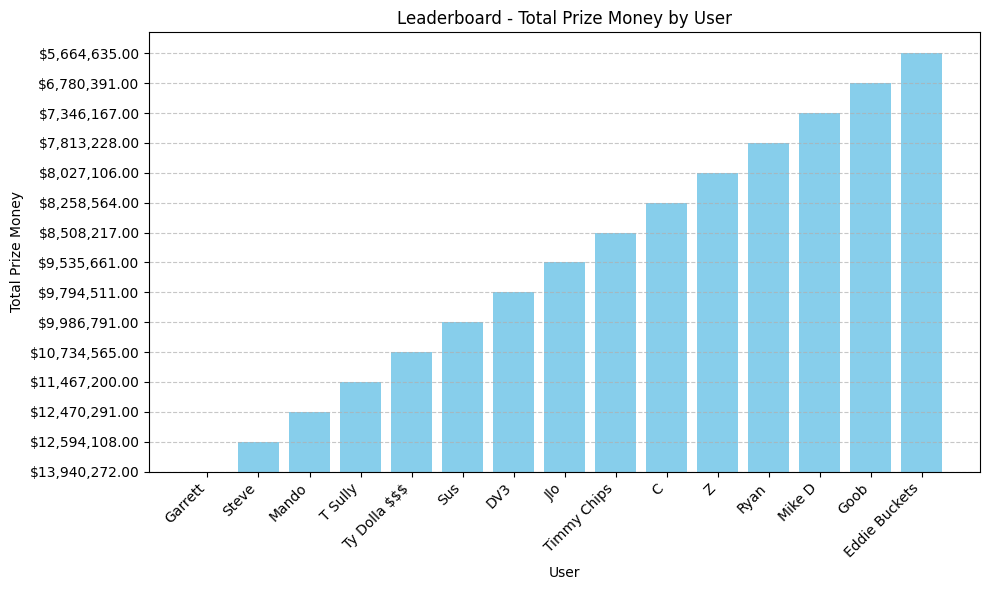

In [17]:
leaderboard_chart()

In [15]:
pd.DataFrame(fetch_leaderboard(), columns=['username', 'prize_money'])

,username,prize_money
0,Garrett,"$13,940,272.00"
1,Steve,"$12,594,108.00"
2,Mando,"$12,470,291.00"
3,T Sully,"$11,467,200.00"
4,Ty Dolla $$$,"$10,734,565.00"
5,Sus,"$9,986,791.00"
6,DV3,"$9,794,511.00"
7,Jlo,"$9,535,661.00"
8,Timmy Chips,"$8,508,217.00"
9,C,"$8,258,564.00"
